In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"  
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, Dropout,  Input, Layer,Conv1DTranspose
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import max_norm

from pandas_datareader import data

from PyEMD import EMD,EEMD,CEEMDAN,Visualisation

import warnings
warnings.filterwarnings("ignore")

In [2]:
shares_name='^GSPC'

In [3]:
start = '2017-01-01'
end = '2019-01-01'
GSPC = pd.DataFrame(data.DataReader(shares_name,"yahoo",start,end)['Adj Close'])#Choose the data
print(GSPC)
print(GSPC.isnull().sum().sort_values(ascending = False))

GSPC_test = pd.DataFrame(data.DataReader(shares_name,"yahoo",start,end)['Adj Close'])#Choose the data
GSPC_test

              Adj Close
Date                   
2017-01-03  2257.830078
2017-01-04  2270.750000
2017-01-05  2269.000000
2017-01-06  2276.979980
2017-01-09  2268.899902
...                 ...
2018-12-24  2351.100098
2018-12-26  2467.699951
2018-12-27  2488.830078
2018-12-28  2485.739990
2018-12-31  2506.850098

[502 rows x 1 columns]
Adj Close    0
dtype: int64


,Adj Close
Date,
2017-01-03,2257.830078
2017-01-04,2270.750000
2017-01-05,2269.000000
2017-01-06,2276.979980
2017-01-09,2268.899902
...,...
2018-12-24,2351.100098
2018-12-26,2467.699951
2018-12-27,2488.830078


In [4]:
start = '2016-01-01'
end = '2019-01-01'
df=pd.DataFrame(data.DataReader(shares_name,"yahoo",start,end)['Adj Close'])
df = df[['Adj Close']]

In [5]:
def create_noisy(data):
    data_noisy = pd.DataFrame()
    for i in range(0,100):
        data_noisy= pd.concat([data_noisy,pd.Series(data.values[:,0])], axis=1)
    return data_noisy.T

In [6]:
def create_pure(data):
    data_pure = pd.DataFrame()
    for i in range(2,52):
        data_pure['SMA{}'.format(i)] = 0
        data_pure['SMA{}'.format(i)] = data[['Adj Close']].rolling(window=i).mean()
    
    data_pure=data_pure.iloc[:,-len(GSPC_noisy.T):]
    data=data.iloc[-len(GSPC_noisy.T):]
    for i in range(2,52):
        data_pure['EMA{}'.format(i)] = 0
        data_pure['EMA{}'.format(i)] = data[['Adj Close']].ewm(span=i, adjust=False).mean()
    
    return data_pure.T

In [7]:
GSPC_noisy=create_noisy(GSPC)

GSPC_pure=create_pure(df).iloc[:,-len(GSPC_noisy.T):]

In [8]:
mm_t_g = MinMaxScaler()
noise_mm = mm_t_g.fit_transform(GSPC_noisy.T).T
prue_mm=mm_t_g.fit_transform(GSPC_pure.T).T
print(prue_mm.shape)
print(noise_mm.shape)

(100, 502)
(100, 502)


In [9]:
X_train_mm = np.asarray(noise_mm)
X_train_mm=X_train_mm.reshape((len(X_train_mm), len(X_train_mm[0]), 1))
Y_train_mm = np.asarray(prue_mm)
Y_train_mm=Y_train_mm.reshape((len(Y_train_mm), len(Y_train_mm[0]), 1))
X_train_mm, X_val_mm, Y_train_mm, Y_val_mm = train_test_split(X_train_mm, Y_train_mm, test_size=0.2,random_state=1)

In [10]:
keras.backend.clear_session()

In [11]:
def set_model_encoding_mm():
    model = Sequential()
    model.add(Conv1D(128, kernel_size=3, activation='relu',kernel_constraint=max_norm(2), kernel_initializer='he_uniform',input_shape=(None, 1)))
    model.add(Conv1D(32, kernel_size=3,activation='relu',kernel_constraint=max_norm(2), kernel_initializer='he_uniform'))
    model.add(Conv1DTranspose(32, kernel_size=3, activation='relu',kernel_constraint=max_norm(2), kernel_initializer='he_uniform'))
    model.add(Conv1DTranspose(128, kernel_size=3,activation='relu',kernel_constraint=max_norm(2), kernel_initializer='he_uniform'))
    model.add(Conv1D(1,kernel_size=3,activation='sigmoid', padding='same'))
    model.compile(optimizer='adam' , loss='binary_crossentropy')
    
    return model
modelen_mm = set_model_encoding_mm()
modelen_mm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 128)         512       
                                                                 
 conv1d_1 (Conv1D)           (None, None, 32)          12320     
                                                                 
 conv1d_transpose (Conv1DTra  (None, None, 32)         3104      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, None, 128)        12416     
 ranspose)                                                       
                                                                 
 conv1d_2 (Conv1D)           (None, None, 1)           385       
                                                                 
Total params: 28,737
Trainable params: 28,737
Non-traina

In [12]:
history_mm = modelen_mm.fit(X_train_mm, Y_train_mm, validation_data = (X_val_mm, Y_val_mm), epochs=20, batch_size=10, verbose=0)

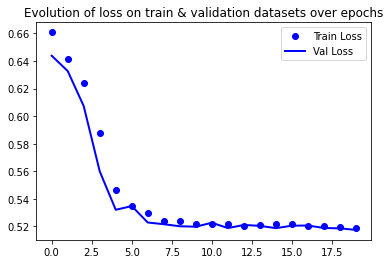

In [13]:
# Check how loss & mae went down
epoch_loss = history_mm.history['loss']
epoch_val_loss = history_mm.history['val_loss']

plt.figure()
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'bo', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'b', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')


plt.show()

1/1 [==============================] - 0s 111ms/step


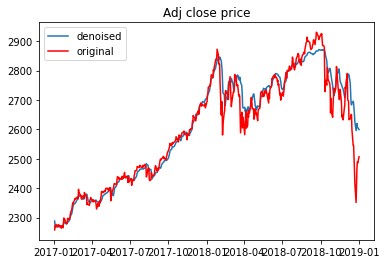

In [14]:
mm_t = MinMaxScaler()
noise_mm_T=mm_t.fit_transform(GSPC_test)
Y_test_mm_cnn = modelen_mm.predict(noise_mm_T.T)
Y_test_mm_cnn=Y_test_mm_cnn.reshape((len(GSPC_test),1))
pure_mm_cnn = mm_t.inverse_transform(Y_test_mm_cnn)
noise_mm_T=pd.DataFrame(noise_mm_T,columns=['Adj Close'],index=GSPC_test.index)
Y_test_mm_cnn=pd.DataFrame(Y_test_mm_cnn,columns=['Adj Close'],index=GSPC_test.index)
pure_mm_cnn=pd.DataFrame(pure_mm_cnn,columns=['Adj Close'],index=GSPC_test.index)
plt.figure()
plt.plot(pure_mm_cnn)
plt.plot(GSPC_test,'r')
plt.title('Adj close price')
plt.legend(['denoised', 'original'], loc='upper left')

# regression

In [176]:
original=GSPC_test
recon=pure_mm_cnn

In [177]:
def features(dataset):
    ret_dataset=pd.DataFrame(index=dataset.index)
    for i in range(2,52,1):
        window = i
        # Volatility
        ret_dataset[str('SMA'+str(i))] = talib.SMA(dataset['Adj Close'],timeperiod=window).shift(1)
        ret_dataset[str('EMA'+str(i))] = talib.EMA(dataset['Adj Close'],timeperiod=window).shift(1)
        ret_dataset[str('STDDEV'+str(i))] = talib.STDDEV(dataset['Adj Close'],timeperiod=window).shift(1)
        ret_dataset[str('Lag'+str(i))] = dataset['Adj Close'].shift(i)
    return ret_dataset

In [178]:
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
import talib
splits=10

1614.2703158884515
1602.6088675507685
9763.699783126029
5364.746767666282
4500.460283327393
3042.085735664135
1908.9501884405206
33250.66439186509
10570.928050765177
8357.479514752946
The last MSE: 8357.479514752946
The average MSE: 7997.589389904679


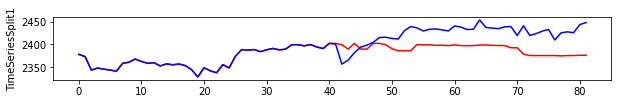

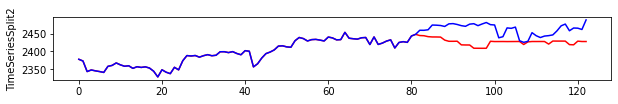

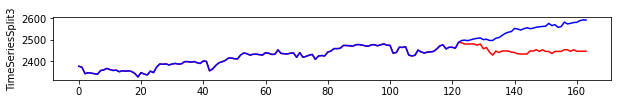

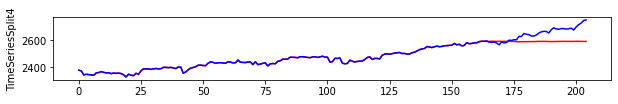

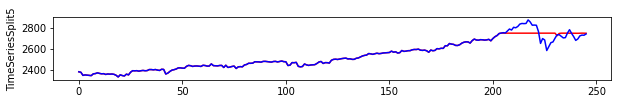

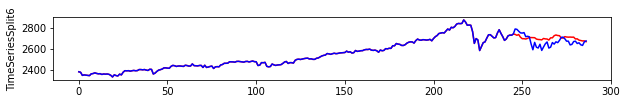

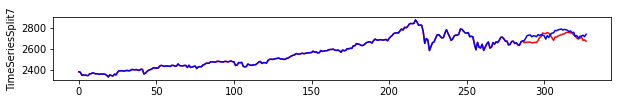

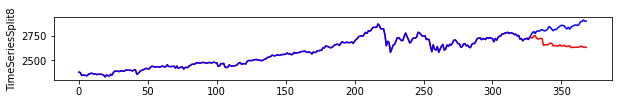

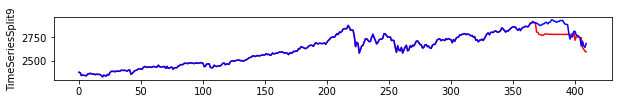

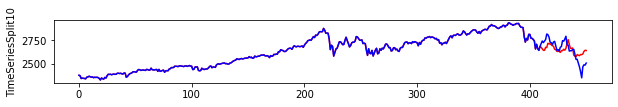

In [179]:
recon_fea=features(recon)
recon_fea=recon_fea.iloc[51:]
original_m=original.iloc[51::]
recon_m=recon.iloc[51::]
tscv = TimeSeriesSplit(n_splits=splits)
msetestav=0

for train_index, test_index in tscv.split(recon_fea):
    model = xgb.XGBRegressor()
    model.fit(recon_fea.iloc[train_index,:],original_m.iloc[train_index,:])
    test_predict=model.predict(recon_fea.iloc[test_index,:])
    msetest=mean_squared_error(original_m.iloc[test_index,:],test_predict)
    i=1+int(len(train_index)/int(len(recon_fea)/splits))
    plt.figure(figsize=(10,15))
    plt.subplot(1 +splits,1,i)
    past=np.asarray(original_m.iloc[train_index,:]).reshape(len(original_m.iloc[train_index,:]))
    whole=np.concatenate((past, test_predict))
    true=np.asarray(original_m.iloc[test_index,:]).reshape(len(original_m.iloc[test_index,:]))
    whole_t=np.concatenate((past, true))
    plt.plot(whole,"r",label='Predicted')
    plt.plot(whole_t,"b",label='Original')
    plt.ylabel('TimeSeriesSplit'+str(i))
    print(msetest)
    msetestav+=msetest
msetestav=msetestav/splits
print('The last MSE:',msetest)
print('The average MSE:',msetestav)

In [96]:
from bayes_opt import BayesianOptimization
def rf_do(max_depth, learning_rate, n_estimators, min_child_weight, subsample, colsample_bytree,reg_alpha,reg_lambda,scale_pos_weight,gamma):
    val = xgb.XGBRegressor(max_depth = round(max_depth),
                           learning_rate = float(learning_rate),
                           n_estimators = round(n_estimators),
                           min_child_weight = round(min_child_weight),
                           #max_delta_step = float(max_delta_step),
                           subsample = float(subsample),
                           colsample_bytree = float(colsample_bytree),
                           reg_alpha = float(reg_alpha),
                           reg_lambda = float(reg_lambda),
                           scale_pos_weight = float(scale_pos_weight),
                           gamma = float(gamma),
                           eval_metric=mean_squared_error)
    msetest=0
    val.fit(recon_fea.iloc[train_index,:],original_m.iloc[train_index,:])
    test_predict=val.predict(recon_fea.iloc[test_index,:])
    msetest=-1*mean_squared_error(recon_m.iloc[test_index,:],test_predict)
    return msetest

In [97]:
# rf_bo = BayesianOptimization(
#         rf_do,
#                 {'max_depth':(1,20),
#                 'learning_rate': (0.01,0.3),
#                 'n_estimators': (100,1000),
#                 'min_child_weight': (0,2),
#                 #'max_delta_step': (0.01,1),
#                 'subsample':(0.5,1),
#                 'colsample_bytree': (0.5,1),
#                 'reg_alpha': (0.01,1),
#                 'reg_lambda': (0.2,1),
#                 'scale_pos_weight': (0.2,1),
#                 'gamma':(0,1)}
#     )
# rf_bo.maximize()#init_points=20, n_iter=10
# rf_bo_p=rf_bo.max
# rf_bo_p['params']['max_depth'] = round(rf_bo_p['params']['max_depth'])
# rf_bo_p['params']['n_estimators'] = round(rf_bo_p['params']['n_estimators'])
# rf_bo_p['params']['min_child_weight'] = round(rf_bo_p['params']['min_child_weight'])
# rf_bo_p

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -1.544e+0 |  0.59     |  0.07548  |  0.2623   |  7.573    |  0.6009   |  317.7    |  0.4519   |  0.5307   |  0.7721   |  0.6963   |
|  2        | -1.061e+0 |  0.5132   |  0.598    |  0.2591   |  10.67    |  1.814    |  683.6    |  0.1013   |  0.2797   |  0.3772   |  0.5945   |
|  3        | -1.735e+0 |  0.7017   |  0.6356   |  0.2345   |  17.31    |  0.5564   |  187.0    |  0.4136   |  0.8658   |  0.9369   |  0.76     |
|  4        | -1.357e+0 |  0.9597   |  0.8734   |  0.1474   |  16.1     |  1.382    |  337.0    |  0.2673   |  0.9474   |  0.6622   |  0.8342   |
|  5        | -1.469e+0 |  0.7494   |  0.1183   |  0.278    |  11.5     |  1.029    |  517.4    |  0.7558   |  0.8497   |  0

{'target': -8532.7021484375,
 'params': {'colsample_bytree': 0.5709572572082031,
  'gamma': 0.4076082164755588,
  'learning_rate': 0.21030627152070172,
  'max_depth': 12,
  'min_child_weight': 2,
  'n_estimators': 683,
  'reg_alpha': 0.2057485996265018,
  'reg_lambda': 0.8512832072791015,
  'scale_pos_weight': 0.932369548218458,
  'subsample': 0.5681420892955062}}

2153.6456390270373
1824.1284457503295
9295.093117856399
5425.715850428837
3484.9116112458996
1631.735811185546
210.3991635499931
2939.401539982819
2227.2013052033217
4746.077826718005
The last MSE: 4746.077826718005
The average MSE: 3393.831031094819


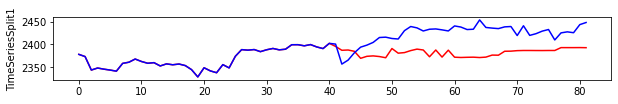

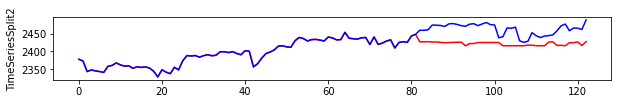

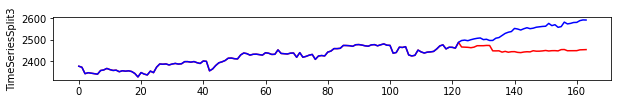

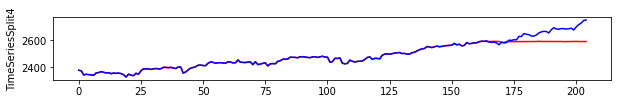

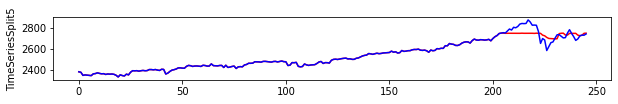

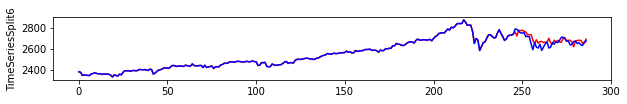

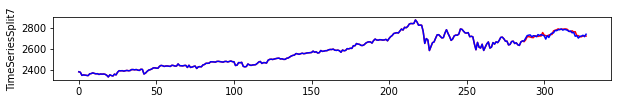

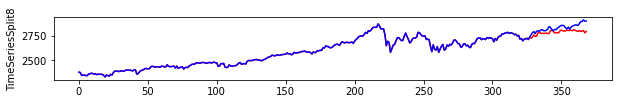

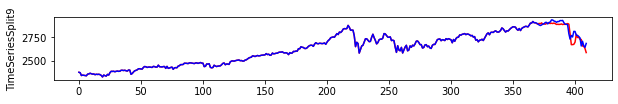

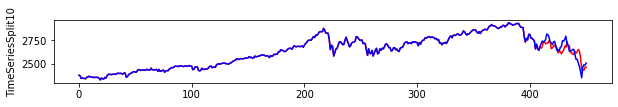

In [98]:
original_fea=features(original)
original_fea=original_fea.iloc[51:]
original_m=original.iloc[51::]
tscv = TimeSeriesSplit(n_splits=splits)
msetestav=0
for train_index, test_index in tscv.split(original_fea):
    model = xgb.XGBRegressor()
    model.fit (original_fea.iloc[train_index,:],original_m.iloc[train_index,:])
    test_predict=model.predict(original_fea.iloc[test_index,:])
    msetest=mean_squared_error(original_m.iloc[test_index,:],test_predict)
    i=1+int(len(train_index)/int(len(recon_fea)/splits))
    plt.figure(figsize=(10,15))
    plt.subplot(1 +splits,1,i)
    past=np.asarray(original_m.iloc[train_index,:]).reshape(len(original_m.iloc[train_index,:]))
    whole=np.concatenate((past, test_predict))
    true=np.asarray(original_m.iloc[test_index,:]).reshape(len(original_m.iloc[test_index,:]))
    whole_t=np.concatenate((past, true))
    plt.plot(whole,"r",label='Predicted')
    plt.plot(whole_t,"b",label='Original')
    plt.ylabel('TimeSeriesSplit'+str(i))
    print(msetest)
    msetestav+=msetest
msetestav=msetestav/splits
print('The last MSE:',msetest)
print('The average MSE:',msetestav)

In [24]:
def rf_oo(max_depth, learning_rate, n_estimators, min_child_weight, subsample, colsample_bytree,reg_alpha,reg_lambda,scale_pos_weight,gamma):
    val = xgb.XGBRegressor(max_depth = round(max_depth),
                           learning_rate = float(learning_rate),
                           n_estimators = round(n_estimators),
                           min_child_weight = round(min_child_weight),
                           subsample = float(subsample),
                           colsample_bytree = float(colsample_bytree),
                           reg_alpha = float(reg_alpha),
                           reg_lambda = float(reg_lambda),
                           scale_pos_weight = float(scale_pos_weight),
                           gamma = float(gamma),
                           eval_metric=mean_squared_error)
    msetest=0
    val.fit(original_fea.iloc[train_index,:],original_m.iloc[train_index,:])
    test_predict=val.predict(original_fea.iloc[test_index,:])
    msetest=-1*mean_squared_error(original_m.iloc[test_index,:],test_predict)
    return msetest

In [25]:
# rf_bo = BayesianOptimization(
#         rf_oo,
#                 {'max_depth':(1,20),
#                 'learning_rate': (0.01,0.3),
#                 'n_estimators': (100,1000),
#                 'min_child_weight': (0,2),
#                 'subsample':(0.5,1),
#                 'colsample_bytree': (0.5,1),
#                 'reg_alpha': (0.01,1),
#                 'reg_lambda': (0.2,1),
#                 'scale_pos_weight': (0.2,1),
#                 'gamma':(0,1)}
#     )
# rf_bo.maximize()#init_points=20, n_iter=10
# rf_bo_p=rf_bo.max
# rf_bo_p['params']['max_depth'] = round(rf_bo_p['params']['max_depth'])
# rf_bo_p['params']['n_estimators'] = round(rf_bo_p['params']['n_estimators'])
# rf_bo_p['params']['min_child_weight'] = round(rf_bo_p['params']['min_child_weight'])
# rf_bo_p

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -5.258e+0 |  0.7077   |  0.8908   |  0.173    |  9.997    |  1.203    |  387.3    |  0.5004   |  0.3636   |  0.2959   |  0.5698   |
|  2        | -3.779e+0 |  0.6956   |  0.5332   |  0.2593   |  15.72    |  0.708    |  493.2    |  0.82     |  0.5532   |  0.2391   |  0.6718   |
|  3        | -4.527e+0 |  0.7734   |  0.553    |  0.1377   |  8.541    |  1.755    |  557.0    |  0.8187   |  0.5457   |  0.6734   |  0.5264   |
|  4        | -5.89e+03 |  0.7096   |  0.6387   |  0.07526  |  1.391    |  0.9827   |  430.4    |  0.5868   |  0.6308   |  0.9383   |  0.5231   |
|  5        | -4.025e+0 |  0.6234   |  0.8038   |  0.2057   |  7.985    |  0.08661  |  739.3    |  0.6393   |  0.4216   |  0

{'target': -2708.629365394755,
 'params': {'colsample_bytree': 0.9543582276282707,
  'gamma': 0.659082252517641,
  'learning_rate': 0.27284288574836163,
  'max_depth': 7,
  'min_child_weight': 2,
  'n_estimators': 234,
  'reg_alpha': 0.102482649535048,
  'reg_lambda': 0.7405336657332398,
  'scale_pos_weight': 0.9405198112610507,
  'subsample': 0.763571262483633}}

# EMDCNN

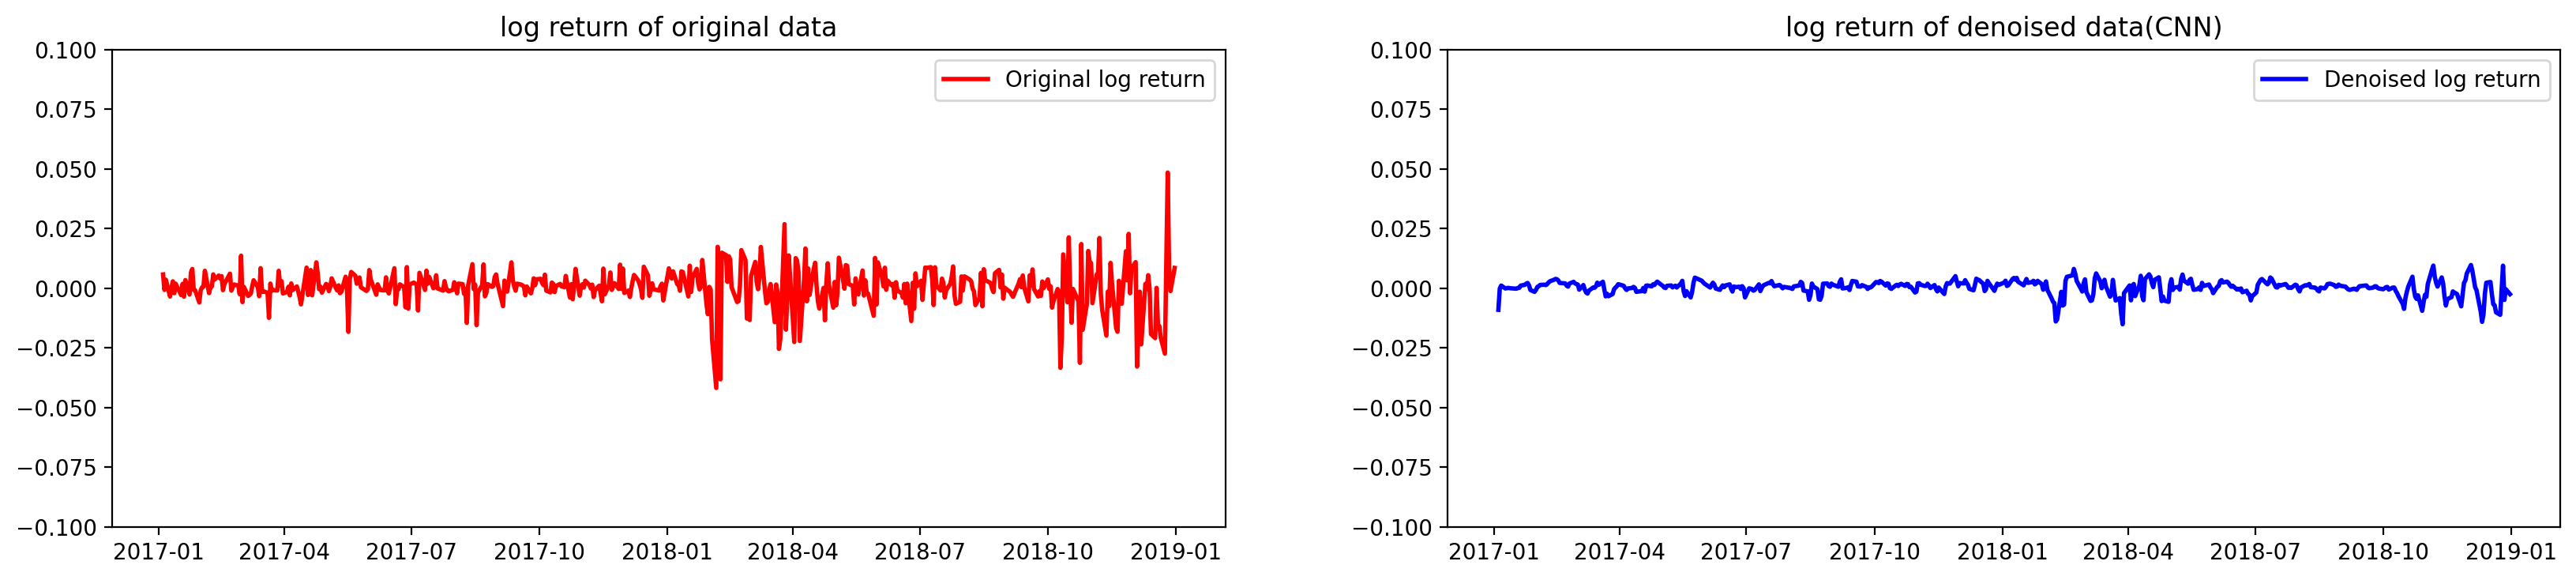

In [16]:
# Log Returns
GSPC_test_n=GSPC_test.copy()
GSPC_test_n['log_ret'] = np.log(GSPC_test.iloc[:,0]).diff()
pure_mm_cnn['log_ret'] = np.log(pure_mm_cnn.iloc[:,0]).diff()


plt.figure(figsize=(20,4),dpi=200)
plt.subplot(1,2,1)
plt.plot(GSPC_test_n['log_ret'], 'r-', linewidth=2, label='Original log return')
plt.ylim(-0.1,0.1)
plt.title('log return of original data')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(pure_mm_cnn['log_ret'] , 'b-', linewidth=2, label='Denoised log return')
plt.ylim(-0.1,0.1)
plt.title('log return of denoised data(CNN)')
plt.legend(loc='best')


plt.show()

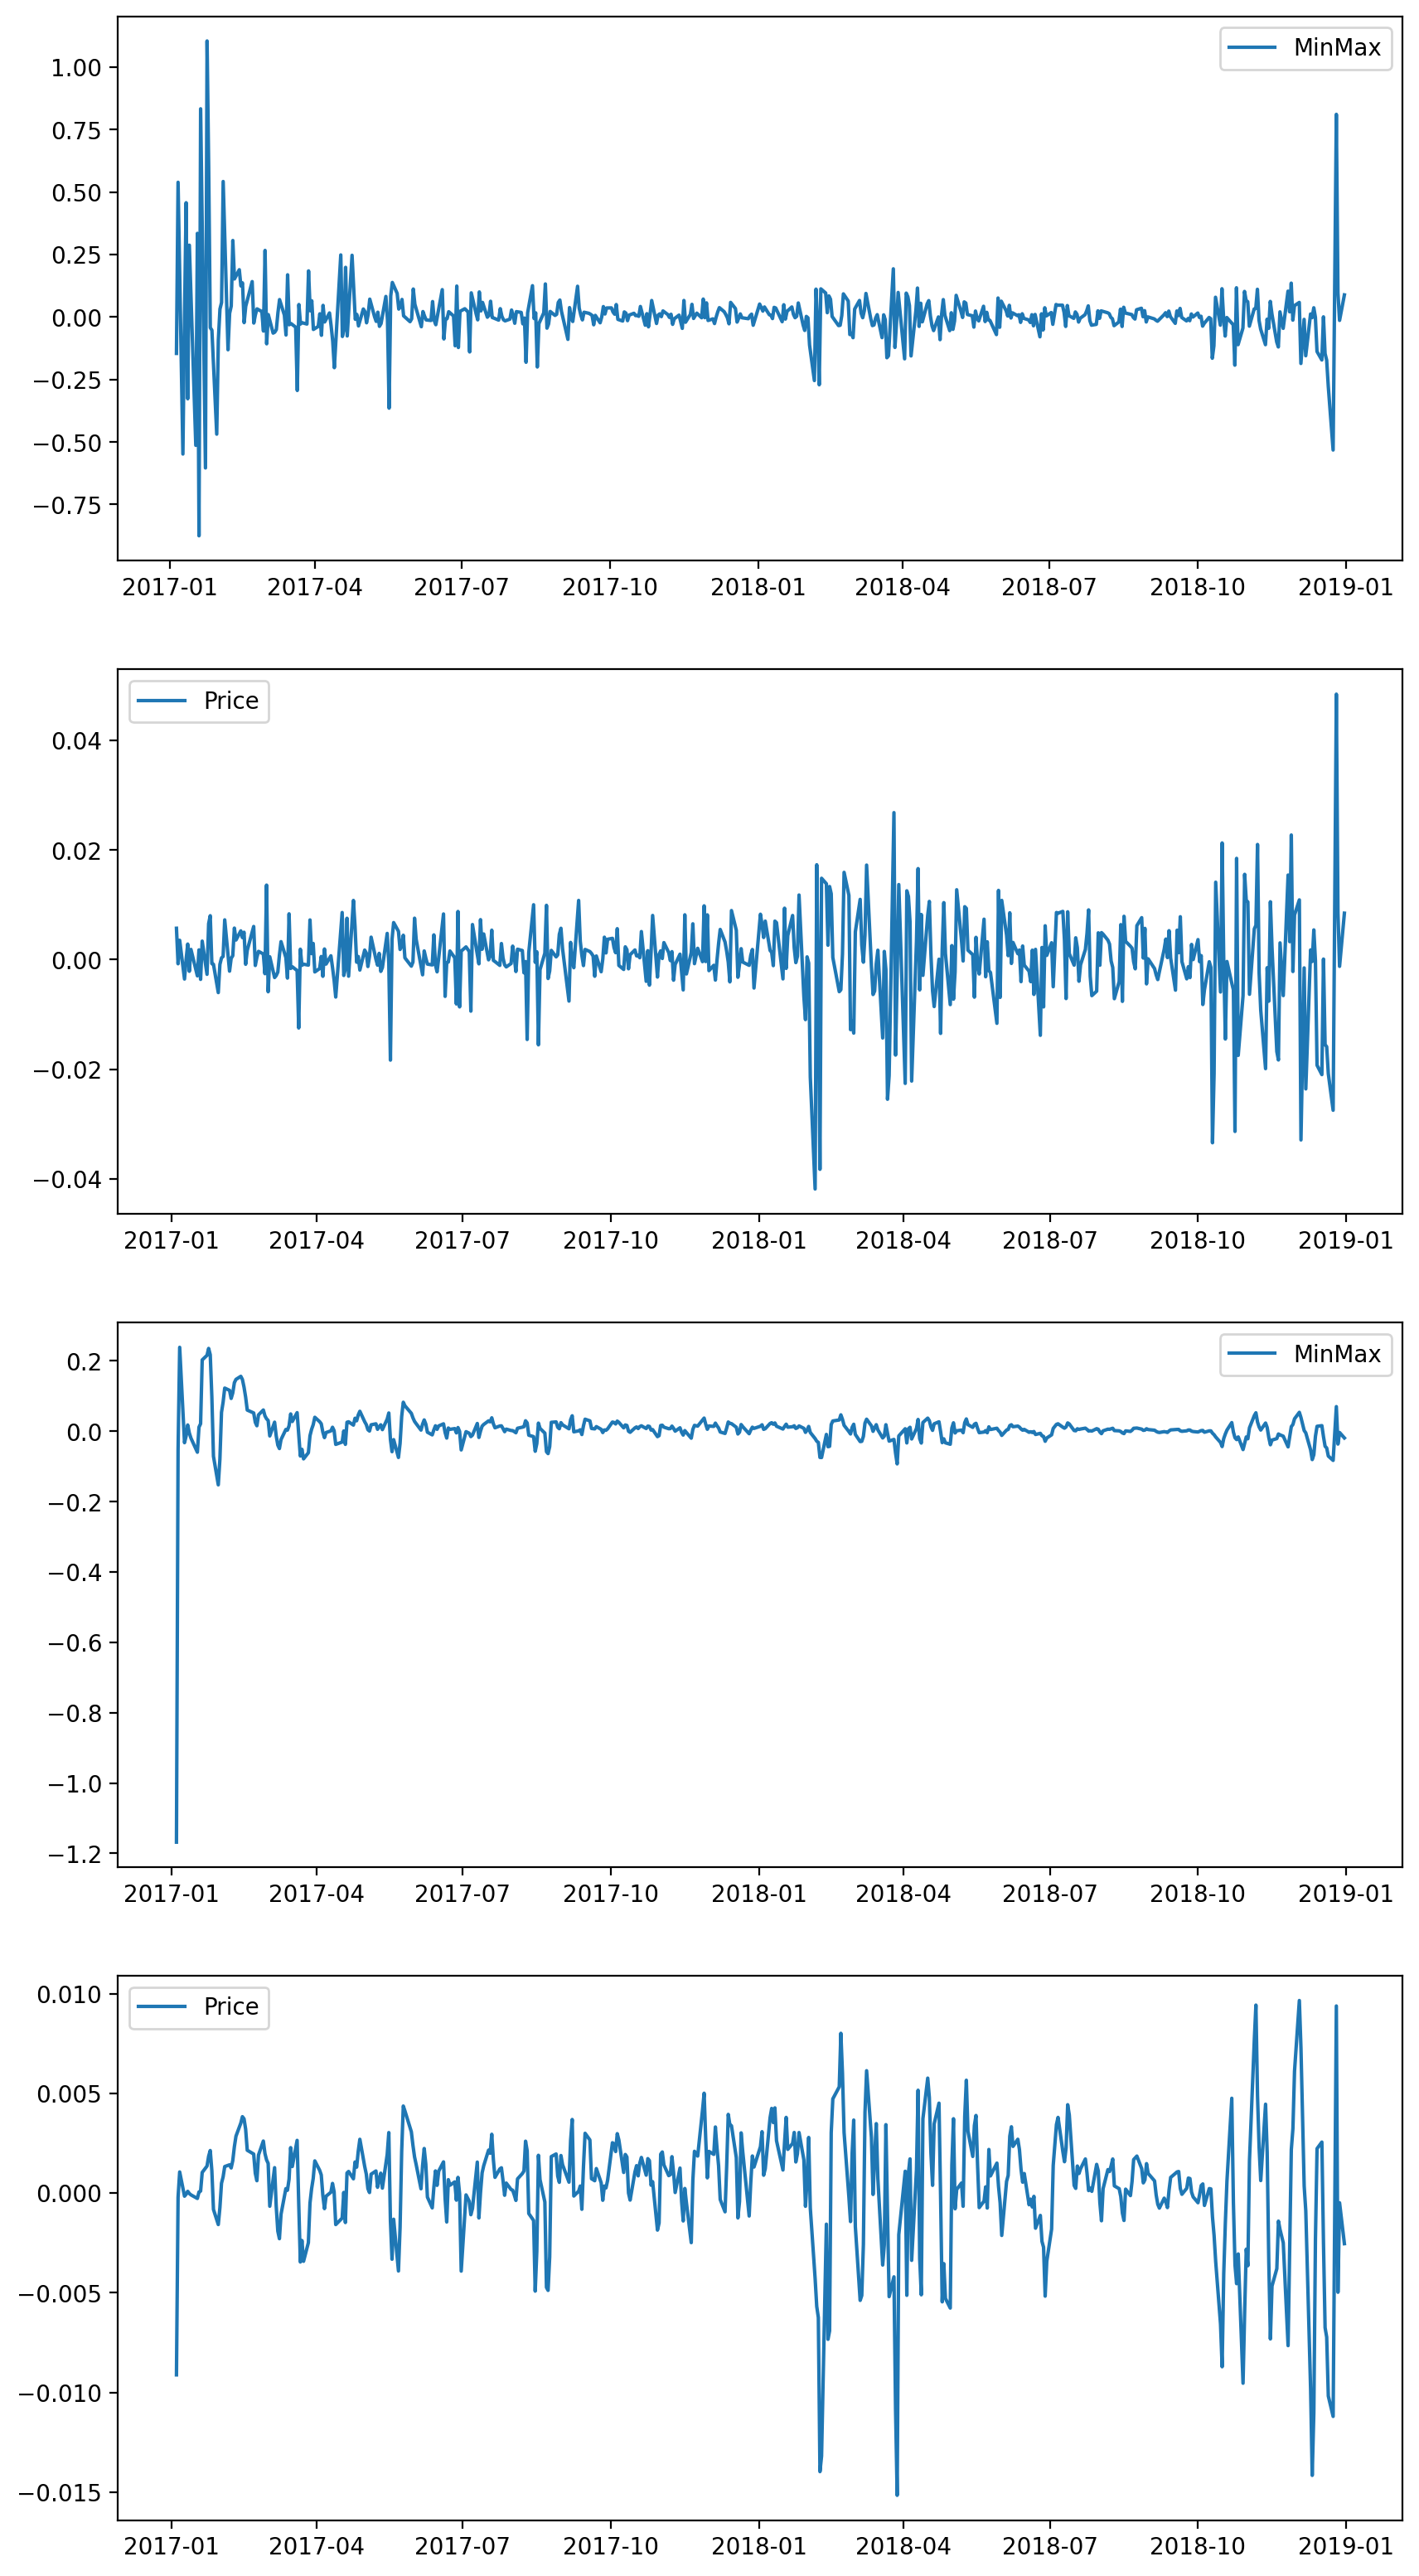

In [17]:
a= np.log(noise_mm_T.iloc[:,0]).diff()
b= np.log(Y_test_mm_cnn.iloc[:,0]).diff()
plt.figure(figsize=(10,20),dpi=200)
plt.subplot(4,1,1)
plt.plot(a,label='MinMax')
plt.legend()
plt.subplot(4,1,2)
plt.plot(GSPC_test_n['log_ret'],label='Price')
plt.legend()
plt.subplot(4,1,3)
plt.plot(b,label='MinMax')
plt.legend()
plt.subplot(4,1,4)
plt.plot(pure_mm_cnn['log_ret'],label='Price')
plt.legend()

In [182]:
def svmf1_ori(dataset,dataset2,long_predict=10,percentage=0.8):
    f11=np.empty(0)
    f12=np.empty(0)
    max_t=0
    if dataset['log_ret'].max()>dataset2['log_ret'].max():
        max_t=dataset2['log_ret'].max()
    else:
        max_t=dataset['log_ret'].max()
    for n in np.arange(0.0, (percentage*max_t), (percentage*max_t)/50):#get multiple threshold
        threshold = n
        # for dataset
        daily_label=np.empty(0)#make the data labelled
        for i in range(0,len(dataset)):
            if dataset.iloc[i,1]<-threshold:
                n=-1
                daily_label=np.append(daily_label,n)
            elif abs(dataset.iloc[i,1])<=threshold:
                n=0
                daily_label=np.append(daily_label,n)
            else:
                n=1
                daily_label=np.append(daily_label,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(1,len(dataset)-long_predict):
            X=pd.concat([X, pd.DataFrame(dataset.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X=np.array(X)
        Y=np.array(Y[0])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=1,shuffle=False)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        model = svc_rbf.fit(X_train,Y_train)
        Y_pred = model.predict(X_test)
        f1 = f1_score(Y_test,Y_pred,average='weighted')
        f11=np.append(f11,f1)
        
        # for dataset2
    for n in np.arange(0.0, (percentage*max_t), (percentage*max_t)/50):#get multiple threshold
        threshold = n
        daily_label2=np.empty(0)#make the data labelled
        for i in range(0,len(dataset2)):
            if dataset.iloc[i,1]<-threshold:
                n=-1
                daily_label2=np.append(daily_label2,n)
            elif abs(dataset.iloc[i,1])<=threshold:
                n=0
                daily_label2=np.append(daily_label2,n)
            else:
                n=1
                daily_label2=np.append(daily_label2,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(1,len(dataset2)-long_predict):
            X=pd.concat([X, pd.DataFrame(dataset2.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label2[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X=np.array(X)
        Y=np.array(Y[0])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=1,shuffle=False)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        model = svc_rbf.fit(X_train,Y_train)
        Y_pred = model.predict(X_test)
        f1 = f1_score(Y_test,Y_pred,average='weighted')
        f12=np.append(f12,f1)
    return f11,f12

In [183]:
original_svm_ori,denoised_svm_ori=svmf1_ori(GSPC_test_n,pure_mm_cnn,long_predict=1,percentage=1)

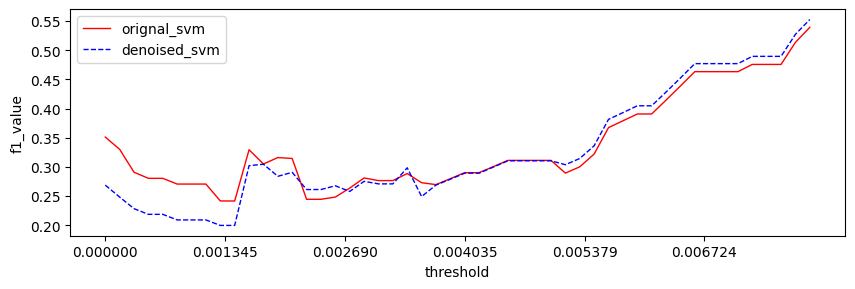

In [184]:
plt.figure(figsize=(10,3),dpi=100)
percentage=1
max_t=0
if GSPC_test_n['log_ret'].max()>pure_mm_cnn['log_ret'].max():
    max_t=pure_mm_cnn['log_ret'].max()
else:
    max_t=GSPC_test_n['log_ret'].max()
plt.plot(np.arange(0.0,(percentage*max_t), (percentage*max_t)/50),original_svm_ori,label='orignal_svm', color='red', linewidth=1.0)
plt.plot(np.arange(0.0,(percentage*max_t), (percentage*max_t)/50),denoised_svm_ori,label='denoised_svm', color='blue', linewidth=1.0, linestyle='--')

plt.xticks(np.arange(0.0,(percentage*max_t), (percentage*max_t)/6))
plt.xlabel('threshold')
plt.ylabel('f1_value')
plt.legend()

In [185]:
def svmf1(dataset,dataset2,long_predict=10,percentage=0.8):
    f11=np.empty(0)
    f12=np.empty(0)
    max_t=0
    if dataset['log_ret'].max()>dataset2['log_ret'].max():
        max_t=dataset2['log_ret'].max()
    else:
        max_t=dataset['log_ret'].max()
    for n in np.arange(0.0, (percentage*max_t), (percentage*max_t)/50):#get multiple threshold
        threshold = n
        # for dataset
        daily_label=np.empty(0)#make the data labelled
        for i in range(0,len(dataset)):
            if dataset.iloc[i,1]<-threshold:
                n=-1
                daily_label=np.append(daily_label,n)
            elif abs(dataset.iloc[i,1])<=threshold:
                n=0
                daily_label=np.append(daily_label,n)
            else:
                n=1
                daily_label=np.append(daily_label,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(1,len(dataset)-long_predict):
            X=pd.concat([X, pd.DataFrame(dataset.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X=np.array(X)
        Y=np.array(Y[0])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=1,shuffle=False)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        model = svc_rbf.fit(X_train,Y_train)
        Y_pred = model.predict(X_test)
        f1 = f1_score(Y_test,Y_pred,average='weighted')
        f11=np.append(f11,f1)
        
        # for dataset2
    for n in np.arange(0.0, (percentage*max_t), (percentage*max_t)/50):#get multiple threshold
        threshold = n
        daily_label2=np.empty(0)#make the data labelled
        for i in range(0,len(dataset2)):
            if dataset2.iloc[i,1]<-threshold:
                n=-1
                daily_label2=np.append(daily_label2,n)
            elif abs(dataset2.iloc[i,1])<=threshold:
                n=0
                daily_label2=np.append(daily_label2,n)
            else:
                n=1
                daily_label2=np.append(daily_label2,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(1,len(dataset2)-long_predict):
            X=pd.concat([X, pd.DataFrame(dataset2.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label2[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X=np.array(X)
        Y=np.array(Y[0])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=1,shuffle=False)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        model = svc_rbf.fit(X_train,Y_train)
        Y_pred = model.predict(X_test)
        f1 = f1_score(Y_test,Y_pred,average='weighted')
        f12=np.append(f12,f1)
    return f11,f12

In [186]:
original_svmg,denoised_svmg=svmf1(GSPC_test_n,pure_mm_cnn,percentage=1)

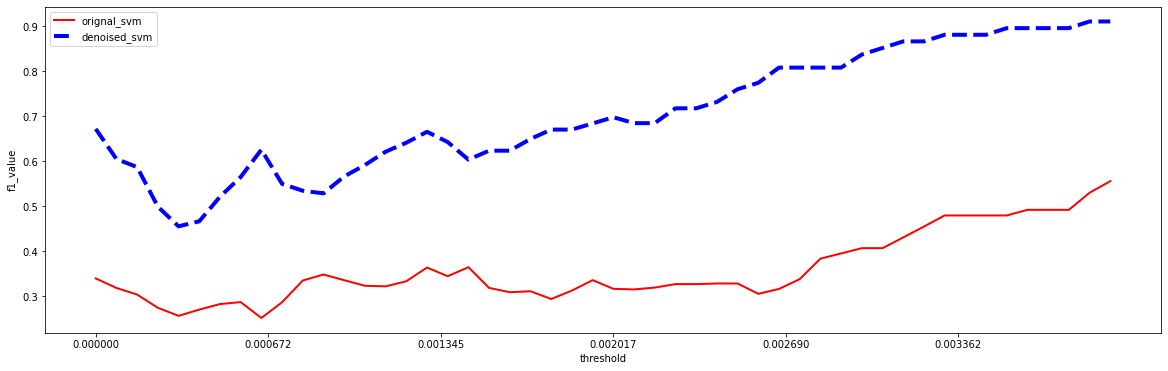

In [187]:
plt.figure(figsize=(20,6))
max_t=0
if GSPC_test_n['log_ret'].max()<pure_mm_cnn['log_ret'].max():
    max_t=GSPC_test_n['log_ret'].max()
else:
    max_t=pure_mm_cnn['log_ret'].max()
plt.plot(np.arange(0.0,(0.5*max_t), (0.5*max_t)/50),original_svmg,label='orignal_svm', color='red', linewidth=2.0)
plt.plot(np.arange(0.0,(0.5*max_t), (0.5*max_t)/50),denoised_svmg,label='denoised_svm', color='blue', linewidth=4.0, linestyle='--')

plt.xticks(np.arange(0.0,(0.5*max_t), (0.5*max_t)/6))
plt.xlabel('threshold')
plt.ylabel('f1_value')
plt.legend()

In [188]:
def svmf1_mm(dataset,dataset2,long_predict=10,percentage=0.8):
    f11=np.empty(0)
    f12=np.empty(0)
    max_t=0
    if dataset['log_ret'].max()>dataset2['log_ret'].max():
        max_t=dataset2['log_ret'].max()
    else:
        max_t=dataset['log_ret'].max()
    for n in np.arange(0.0, (percentage*max_t), (percentage*max_t)/50):#get multiple threshold
        threshold = n
        # for dataset
        daily_label=np.empty(0)#make the data labelled
        for i in range(0,len(dataset)):
            if dataset.iloc[i,1]<-threshold:
                n=-1
                daily_label=np.append(daily_label,n)
            elif abs(dataset.iloc[i,1])<=threshold:
                n=0
                daily_label=np.append(daily_label,n)
            else:
                n=1
                daily_label=np.append(daily_label,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(1,len(dataset)-long_predict):
            X=pd.concat([X, pd.DataFrame(dataset.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X=np.array(X)
        Y=np.array(Y[0])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=1,shuffle=False)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        model = svc_rbf.fit(X_train,Y_train)
        Y_pred = model.predict(X_test)
        f1 = f1_score(Y_test,Y_pred,average='weighted')
        f11=np.append(f11,f1)
        
        # for dataset2
    for n in np.arange(0.0, (percentage*max_t), (percentage*max_t)/50):#get multiple threshold
        threshold = n
        daily_label2=np.empty(0)#make the data labelled
        for i in range(0,len(dataset2)):
            if dataset2.iloc[i,1]<-threshold:
                n=-1
                daily_label2=np.append(daily_label2,n)
            elif abs(dataset2.iloc[i,1])<=threshold:
                n=0
                daily_label2=np.append(daily_label2,n)
            else:
                n=1
                daily_label2=np.append(daily_label2,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(1,len(dataset2)-long_predict):
            X=pd.concat([X, pd.DataFrame(dataset2.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label2[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X=np.array(X)
        Y=np.array(Y[0])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=1,shuffle=False)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        model = svc_rbf.fit(X_train,Y_train)
        Y_pred = model.predict(X_test)
        f1 = f1_score(Y_test,Y_pred,average='weighted')
        f12=np.append(f12,f1)
    return f11,f12

In [189]:
# Log Returns
noise_mm_T_n=noise_mm_T.copy()
noise_mm_T_n['log_ret'] = np.log(noise_mm_T.iloc[1:,0]).diff()
Y_test_mm_cnn['log_ret'] = np.log(Y_test_mm_cnn.iloc[1:,0]).diff()

In [190]:
noise_mm_T_n['log_ret'][np.isinf(noise_mm_T_n['log_ret'])] = 99
Y_test_mm_cnn['log_ret'][np.isinf(Y_test_mm_cnn['log_ret'])] = 99
noise_mm_T_n=noise_mm_T_n.fillna(0)
Y_test_mm_cnn=Y_test_mm_cnn.fillna(0)

In [191]:
original_svmg,denoised_svmg=svmf1_mm(noise_mm_T_n,Y_test_mm_cnn,percentage=0.5)

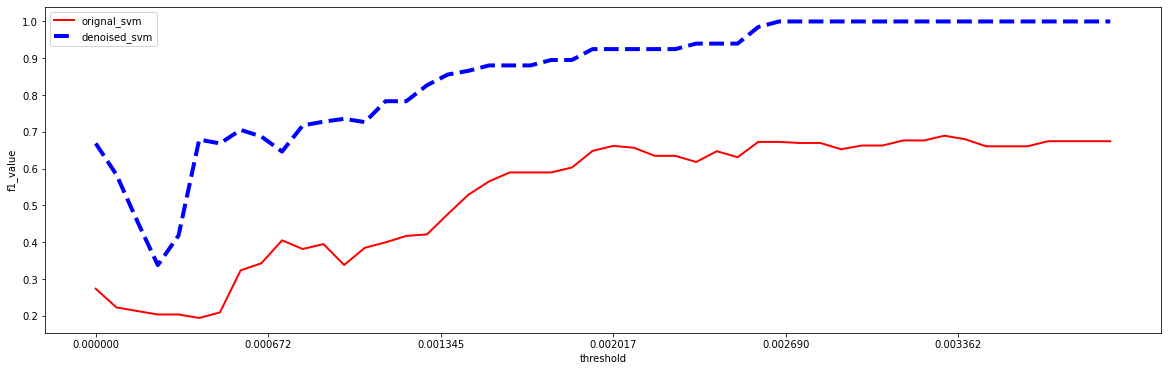

In [192]:
plt.figure(figsize=(20,6))
max_t=0
if GSPC_test_n['log_ret'].max()<pure_mm_cnn['log_ret'].max():
    max_t=GSPC_test_n['log_ret'].max()
else:
    max_t=pure_mm_cnn['log_ret'].max()
plt.plot(np.arange(0.0,(0.5*max_t), (0.5*max_t)/50),original_svmg,label='orignal_svm', color='red', linewidth=2.0)
plt.plot(np.arange(0.0,(0.5*max_t), (0.5*max_t)/50),denoised_svmg,label='denoised_svm', color='blue', linewidth=4.0, linestyle='--')

plt.xticks(np.arange(0.0,(0.5*max_t), (0.5*max_t)/6))
plt.xlabel('threshold')
plt.ylabel('f1_value')
plt.legend()

# Strategies 

## Bollinger band

In [193]:
def bbands(close_prices, window, no_of_stdev):#bollinger  bands, using today's closing price

    rolling_mean = close_prices.rolling(window,min_periods=1).mean()#.shift(1)
    rolling_std = close_prices.rolling(window,min_periods=1).std()#.shift(1)
    

    upper_band = rolling_mean + (rolling_std * no_of_stdev)
    lower_band = rolling_mean - (rolling_std * no_of_stdev)

    return rolling_mean, upper_band, lower_band

In [194]:
def buy_signal_function(dataset):
    buy_signal=pd.DataFrame(columns=['Price'],index=dataset.index)
    buy_signal['Price']=dataset['Adj Close']
    buy_signal['mean'],buy_signal['upper'],buy_signal['lower']=bbands(dataset['Adj Close'],20,2)
    buy_signal['side'] = np.nan 
    buy_signal['signal'] = np.nan 
    for i in range(0,len(dataset)):
        if (buy_signal.iloc[i,0]<buy_signal.iloc[i,3]):
            buy_signal.iloc[i,4]=1
            if (buy_signal.iloc[i-1,0]>=buy_signal.iloc[i-1,3]):
                buy_signal.iloc[i,5]=1
        elif (buy_signal.iloc[i,0]>buy_signal.iloc[i,2]):
            buy_signal.iloc[i,4]=-1
            if (buy_signal.iloc[i-1,0]<=buy_signal.iloc[i-1,2]):
                buy_signal.iloc[i,5]=-1
    return buy_signal

In [195]:
GSPC_test_signal=buy_signal_function(GSPC_test_n)


pure_mm_cnn_signal=buy_signal_function(pure_mm_cnn)


In [196]:

print('GSPC_test_signal:\n',GSPC_test_signal.signal.value_counts(),'\n')
print('pure_mm_cnn_signal:\n',pure_mm_cnn_signal.signal.value_counts(),'\n')


GSPC_test_signal:
 -1.0    17
 1.0    14
Name: signal, dtype: int64 

pure_mm_cnn_signal:
 -1.0    11
 1.0     7
Name: signal, dtype: int64 



In [197]:
print(GSPC_test[GSPC_test_signal.signal == 1.0])
print(GSPC_test[pure_mm_cnn_signal.signal == 1.0])

              Adj Close
Date                   
2017-03-21  2344.020020
2017-04-13  2328.949951
2017-06-29  2419.699951
2017-07-06  2409.750000
2017-08-10  2438.209961
2017-08-17  2430.010010
2018-02-05  2648.939941
2018-02-08  2581.000000
2018-03-22  2643.689941
2018-06-27  2699.629883
2018-10-10  2785.679932
2018-10-24  2656.100098
2018-12-17  2545.939941
2018-12-19  2506.959961
              Adj Close
Date                   
2017-03-23  2345.959961
2017-08-22  2452.510010
2018-02-09  2619.550049
2018-03-26  2658.550049
2018-10-11  2728.370117
2018-12-11  2636.780029
2018-12-20  2467.419922


In [198]:
print(GSPC_test[GSPC_test_signal.signal == -1.0])
print(GSPC_test[pure_mm_cnn_signal.signal == -1.0])

              Adj Close
Date                   
2017-01-25  2298.370117
2017-02-10  2316.100098
2017-02-21  2365.379883
2017-04-25  2388.610107
2017-06-02  2439.070068
2017-07-14  2459.270020
2017-07-19  2473.830078
2017-09-12  2496.479980
2017-10-05  2552.070068
2017-10-27  2581.070068
2017-11-28  2627.040039
2018-01-04  2723.989990
2018-01-12  2786.239990
2018-05-10  2723.070068
2018-06-06  2772.350098
2018-08-27  2896.739990
2018-09-20  2930.750000
              Adj Close
Date                   
2017-02-06  2292.560059
2017-04-25  2388.610107
2017-05-31  2411.800049
2017-07-12  2443.250000
2017-08-09  2474.020020
2017-10-03  2534.580078
2017-11-27  2601.419922
2018-01-09  2751.290039
2018-06-08  2779.030029
2018-08-09  2853.580078
2018-08-30  2901.129883


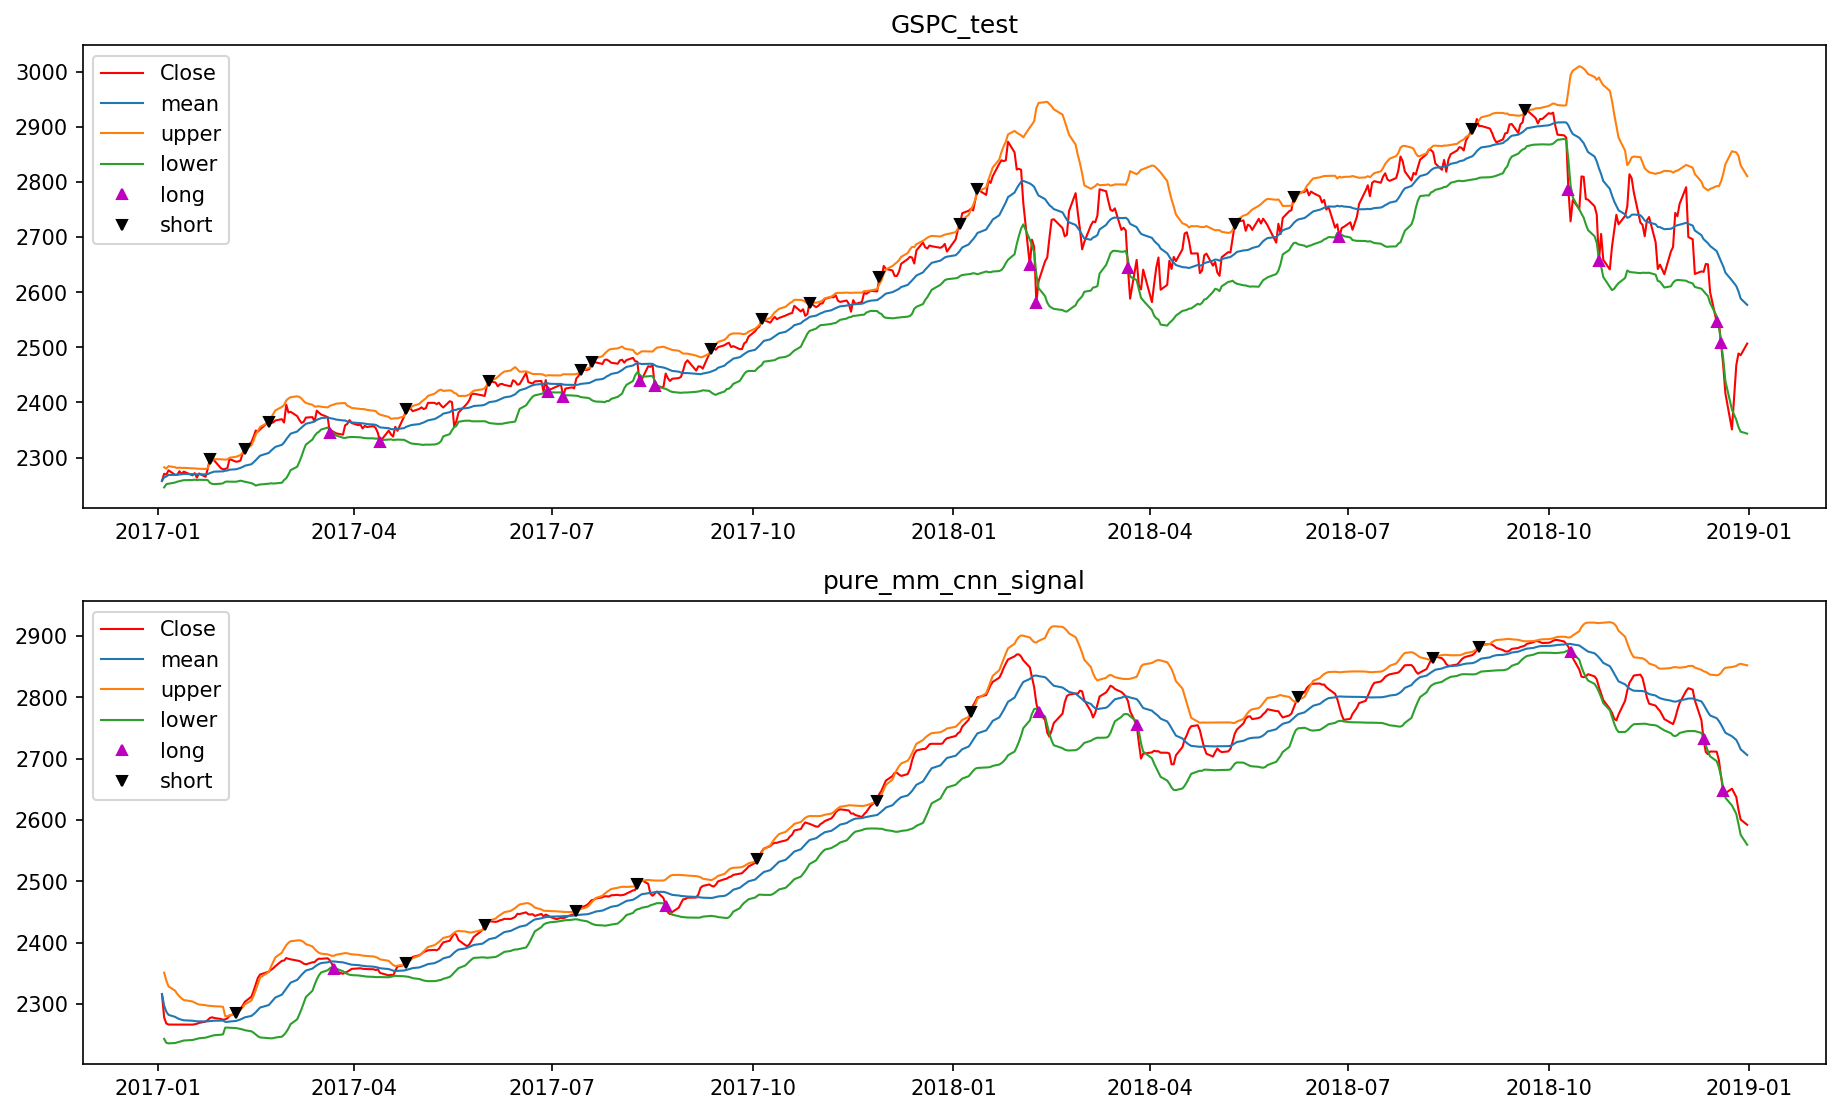

In [199]:
plt.figure(figsize=(15,9),dpi=150)
plt.subplot(2,1,1)
plt.title('GSPC_test')
plt.plot(GSPC_test_signal['Price'], color='r', lw=1,label='Close')
plt.plot(GSPC_test_signal[['mean','upper','lower']], lw=1,label=['mean','upper','lower'])
plt.plot(GSPC_test_signal.loc[GSPC_test_signal.signal == 1.0].index, 
         GSPC_test_signal.Price[GSPC_test_signal.signal == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(GSPC_test_signal.loc[GSPC_test_signal.signal == -1.0].index, 
         GSPC_test_signal.Price[GSPC_test_signal.signal == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()         


plt.subplot(2,1,2)
plt.title('pure_mm_cnn_signal')
plt.plot(pure_mm_cnn_signal['Price'], color='r', lw=1,label='Close')
plt.plot(pure_mm_cnn_signal[['mean','upper','lower']], lw=1,label=['mean','upper','lower'])
plt.plot(pure_mm_cnn_signal.loc[pure_mm_cnn_signal.signal == 1.0].index, 
         pure_mm_cnn_signal.Price[pure_mm_cnn_signal.signal == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(pure_mm_cnn_signal.loc[pure_mm_cnn_signal.signal == -1.0].index, 
         pure_mm_cnn_signal.Price[pure_mm_cnn_signal.signal == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()    


## MACD

In [200]:
def MACD(dataset,short_window = 12,long_window = 26, signal_window=9):
    # Initiate short and long windows

    # Initialise the `signals` dataframe and add the `signal` column
    signals = pd.DataFrame(index=dataset.index)
    signals['signal'] = 0.0

    # Calculate short term moving averages
    signals['short_mavg'] = dataset['Adj Close'].ewm(span=short_window, min_periods=1).mean()

    # Calculate long term moving averages
    signals['long_mavg'] = dataset['Adj Close'].ewm(span=long_window, min_periods=1).mean()
    
    # Calculate DIF 
    signals['DIF'] = signals['short_mavg']-signals['long_mavg']
    
     # Calculate DIF moving averages
    signals['DEA'] = signals['DIF'].ewm(span=signal_window, min_periods=1).mean()

    # Generate signal
    signals['signal'] = np.where(signals['DIF']> signals['DEA'], 1.0, 0.0)   

    # Generate trading orders
    signals['positions'] = signals['signal'].diff()
    return signals

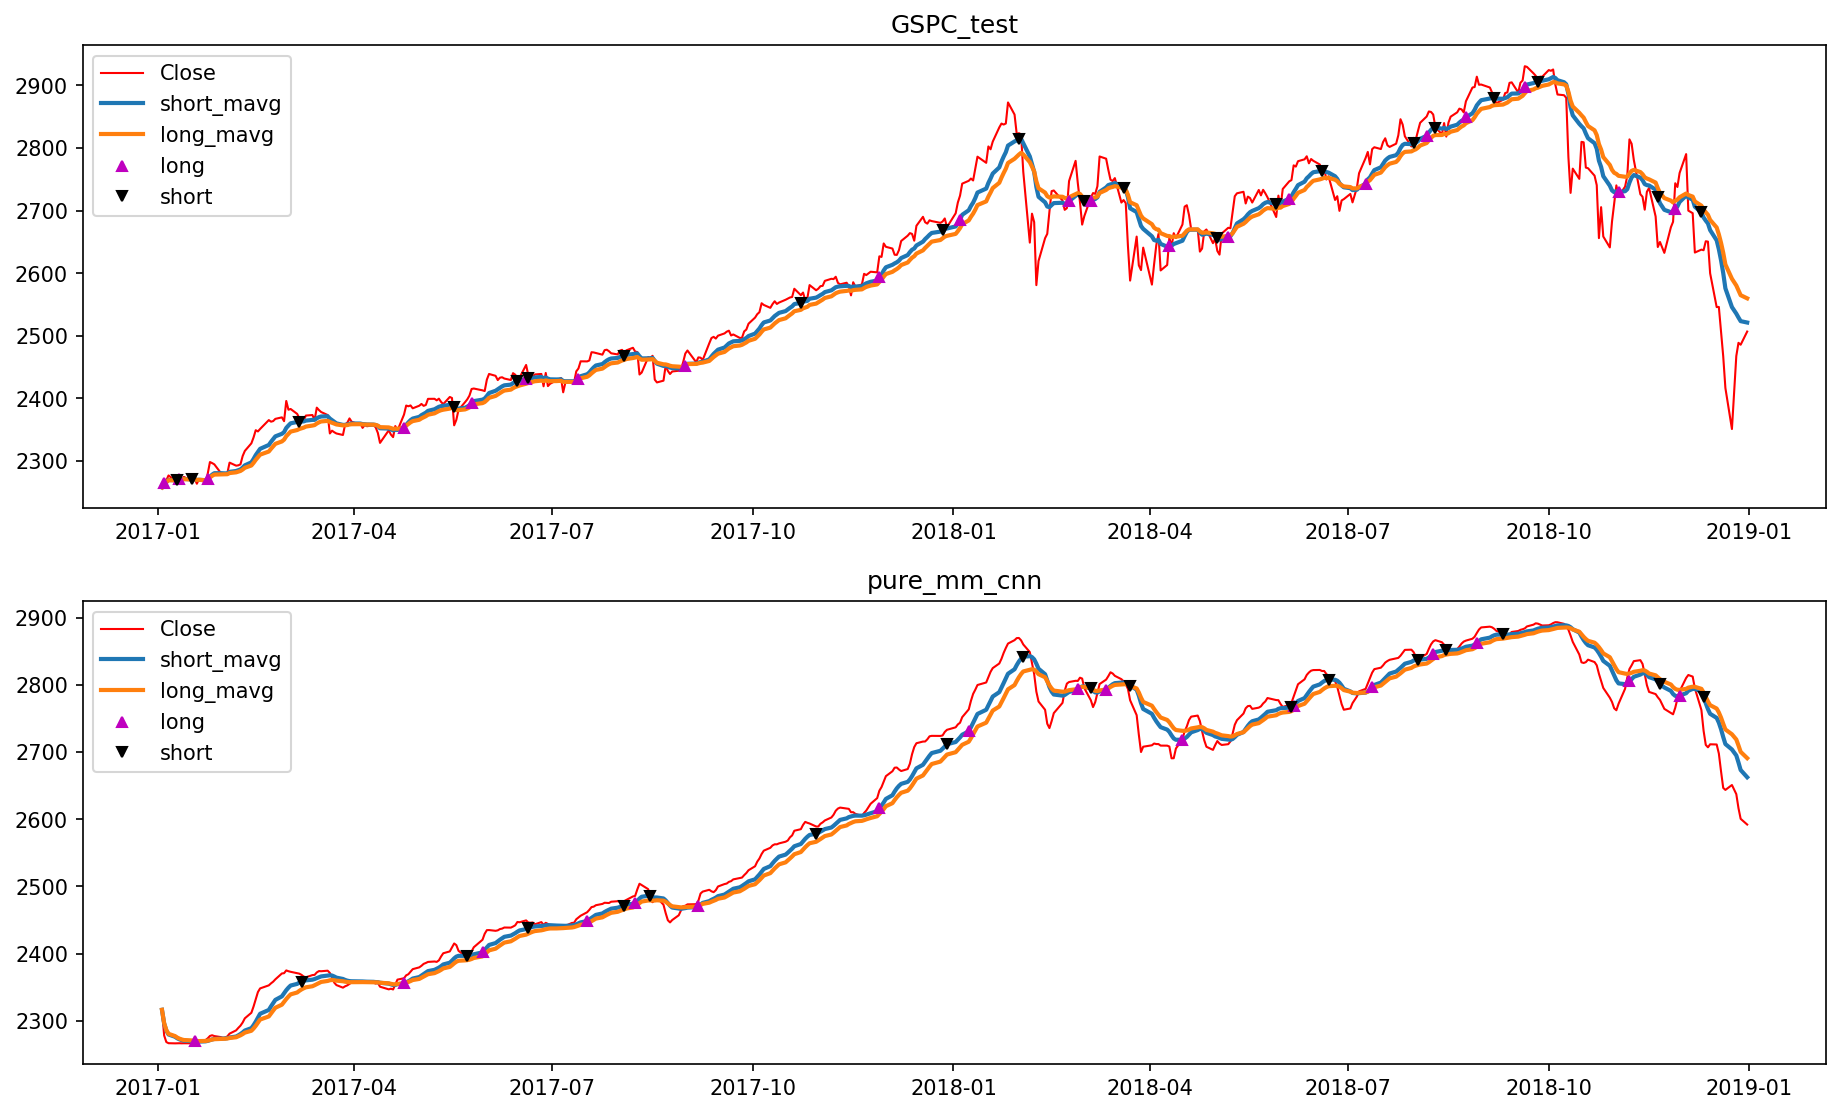

In [201]:
GSPC_test_macd=MACD(GSPC_test_n,short_window = 14,long_window = 22)
pure_mm_cnn_macd=MACD(pure_mm_cnn,short_window = 14,long_window = 22)
#pure_mm_lstm_macd=MACD(pure_mm_lstm,short_window = 14,long_window = 22)

plt.figure(figsize=(15,9),dpi=150)
plt.subplot(2,1,1)
plt.title('GSPC_test')
plt.plot(GSPC_test_n['Adj Close'], color='r', lw=1,label='Close')
plt.plot(GSPC_test_macd[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(GSPC_test_macd.loc[GSPC_test_macd.positions == 1.0].index, 
         GSPC_test_macd.short_mavg[GSPC_test_macd.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(GSPC_test_macd.loc[GSPC_test_macd.positions == -1.0].index, 
         GSPC_test_macd.short_mavg[GSPC_test_macd.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()         


plt.subplot(2,1,2)
plt.title('pure_mm_cnn')
plt.plot(pure_mm_cnn['Adj Close'], color='r', lw=1,label='Close')
plt.plot(pure_mm_cnn_macd[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(pure_mm_cnn_macd.loc[pure_mm_cnn_macd.positions == 1.0].index, 
         pure_mm_cnn_macd.short_mavg[pure_mm_cnn_macd.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(pure_mm_cnn_macd.loc[pure_mm_cnn_macd.positions == -1.0].index, 
         pure_mm_cnn_macd.short_mavg[pure_mm_cnn_macd.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()   



In [202]:
print('GSPC_test_macd:\n',GSPC_test_macd.positions.value_counts(),'\n')
print('pure_mm_cnn_macd:\n',pure_mm_cnn_macd.positions.value_counts(),'\n')

GSPC_test_macd:
  0.0    459
 1.0     21
-1.0     21
Name: positions, dtype: int64 

pure_mm_cnn_macd:
  0.0    467
 1.0     17
-1.0     17
Name: positions, dtype: int64 



In [203]:
print(GSPC_test[GSPC_test_macd['positions']==1])
print(GSPC_test[pure_mm_cnn_macd['positions']==1])

              Adj Close
Date                   
2017-01-04  2270.750000
2017-01-11  2275.320068
2017-01-24  2280.070068
2017-04-24  2374.149902
2017-05-25  2415.070068
2017-06-19  2453.459961
2017-07-13  2447.830078
2017-08-31  2471.649902
2017-11-28  2627.040039
2018-01-04  2723.989990
2018-02-23  2747.300049
2018-03-05  2720.939941
2018-04-10  2656.870117
2018-05-07  2672.629883
2018-06-04  2746.870117
2018-07-09  2784.169922
2018-08-06  2850.399902
2018-08-24  2874.689941
2018-09-20  2930.750000
2018-11-02  2723.060059
2018-11-28  2743.790039
              Adj Close
Date                   
2017-01-18  2271.889893
2017-04-24  2374.149902
2017-05-30  2412.909912
2017-07-17  2459.139893
2017-08-08  2474.919922
2017-09-06  2465.540039
2017-11-28  2627.040039
2018-01-08  2747.709961
2018-02-27  2744.280029
2018-03-12  2783.020020
2018-04-16  2677.840088
2018-06-06  2772.350098
2018-07-12  2798.290039
2018-08-09  2853.580078
2018-08-29  2914.040039
2018-11-07  2813.889893
2018-11-30  2760

In [204]:
print(GSPC_test[GSPC_test_macd['positions']==-1])
print(GSPC_test[pure_mm_cnn_macd['positions']==-1])

              Adj Close
Date                   
2017-01-10  2268.899902
2017-01-17  2267.889893
2017-03-07  2368.389893
2017-05-17  2357.030029
2017-06-15  2432.459961
2017-06-20  2437.030029
2017-08-03  2472.159912
2017-10-23  2564.979980
2017-12-27  2682.620117
2018-01-31  2823.810059
2018-03-02  2691.250000
2018-03-20  2716.939941
2018-05-02  2635.669922
2018-05-29  2689.860107
2018-06-19  2762.590088
2018-07-31  2816.290039
2018-08-10  2833.280029
2018-09-06  2878.050049
2018-09-26  2905.969971
2018-11-20  2641.889893
2018-12-10  2637.719971
              Adj Close
Date                   
2017-03-08  2362.979980
2017-05-23  2398.419922
2017-06-20  2437.030029
2017-08-03  2472.159912
2017-08-15  2464.610107
2017-10-30  2572.830078
2017-12-29  2673.610107
2018-02-02  2762.129883
2018-03-05  2720.939941
2018-03-23  2588.260010
2018-06-05  2748.800049
2018-06-22  2754.879883
2018-08-02  2827.219971
2018-08-15  2818.370117
2018-09-10  2877.129883
2018-11-21  2649.929932
2018-12-11  2636

## MA

In [205]:
def MA(dataset,short_window = 10,long_window = 50):
    # Initiate short and long windows

    # Initialise the `signals` dataframe and add the `signal` column
    signals = pd.DataFrame(index=dataset.index)
    signals['signal'] = 0.0

    # Calculate short term simple moving averages
    signals['short_mavg'] = dataset['Adj Close'].rolling(window=short_window, min_periods=1).mean()

    # Calculate long term simple moving averages
    signals['long_mavg'] = dataset['Adj Close'].rolling(window=long_window, min_periods=1).mean()

    # Generate signal
    signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                                > signals['long_mavg'][short_window:], 1.0, 0.0)   

    # Generate trading orders
    signals['positions'] = signals['signal'].diff()
    return signals

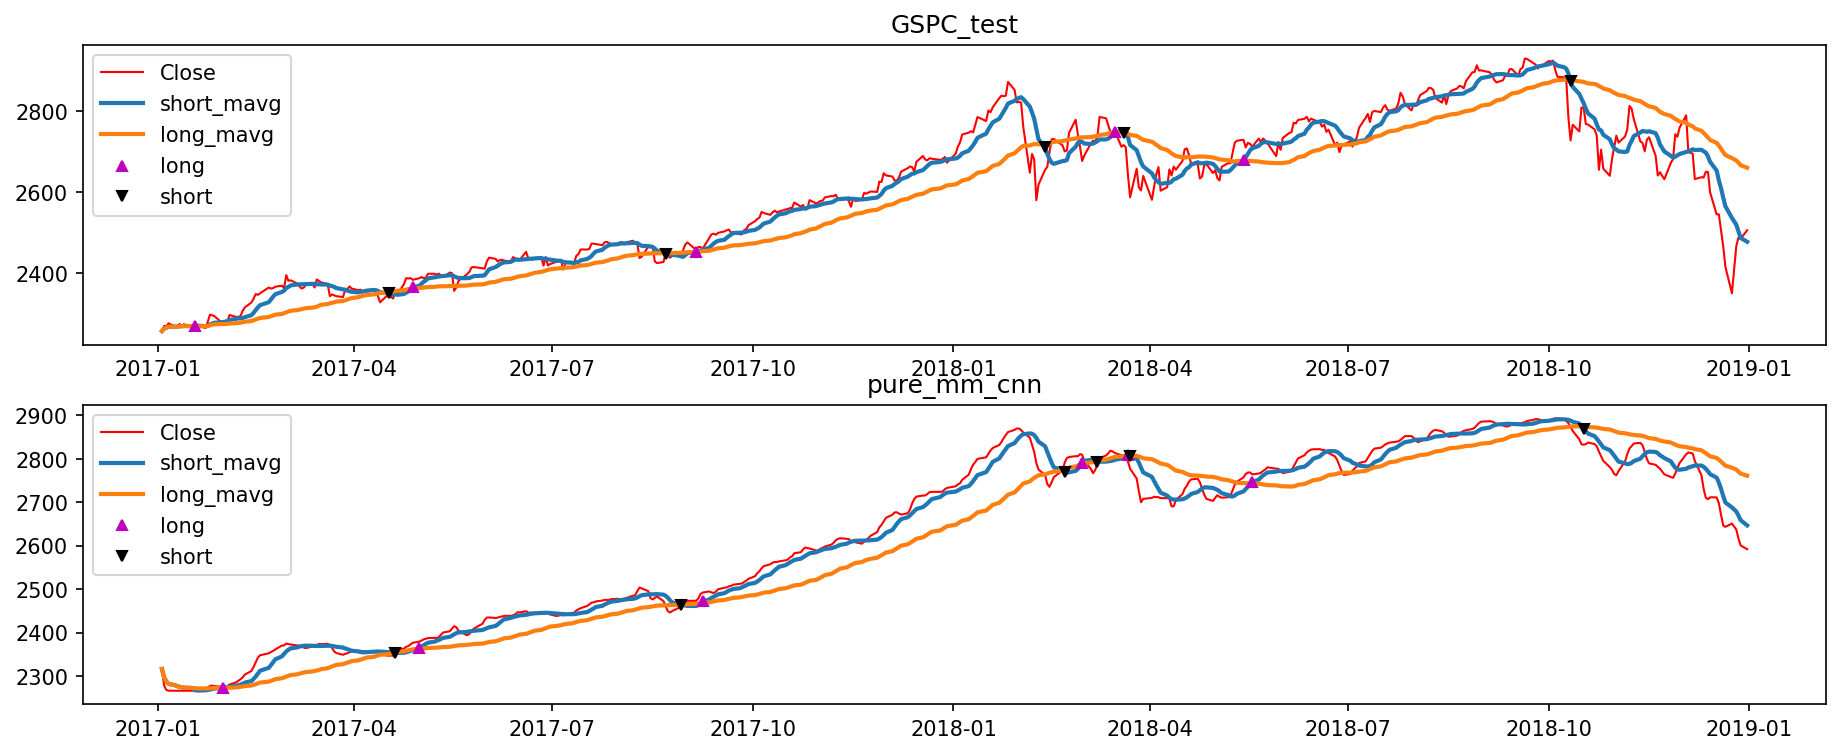

In [206]:
GSPC_test_ma=MA(GSPC_test,short_window = 10,long_window = 50)
pure_mm_cnn_ma=MA(pure_mm_cnn,short_window = 10,long_window = 50)
#pure_mm_lstm_ma=MA(pure_mm_lstm,short_window = 10,long_window = 50)

plt.figure(figsize=(15,9),dpi=150)
plt.subplot(3,1,1)
plt.title('GSPC_test')
plt.plot(GSPC_test['Adj Close'], color='r', lw=1,label='Close')
plt.plot(GSPC_test_ma[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(GSPC_test_ma.loc[GSPC_test_ma.positions == 1.0].index, 
         GSPC_test_ma.short_mavg[GSPC_test_ma.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(GSPC_test_ma.loc[GSPC_test_ma.positions == -1.0].index, 
         GSPC_test_ma.short_mavg[GSPC_test_ma.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()         


plt.subplot(3,1,2)
plt.title('pure_mm_cnn')
plt.plot(pure_mm_cnn['Adj Close'], color='r', lw=1,label='Close')
plt.plot(pure_mm_cnn_ma[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(pure_mm_cnn_ma.loc[pure_mm_cnn_ma.positions == 1.0].index, 
         pure_mm_cnn_ma.short_mavg[pure_mm_cnn_ma.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(pure_mm_cnn_ma.loc[pure_mm_cnn_ma.positions == -1.0].index, 
         pure_mm_cnn_ma.short_mavg[pure_mm_cnn_ma.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()   



In [207]:
print('GSPC_test_ma:\n',GSPC_test_ma.positions.value_counts(),'\n')
print('pure_mm_cnn_ma:\n',pure_mm_cnn_ma.positions.value_counts(),'\n')

GSPC_test_ma:
  0.0    491
 1.0      5
-1.0      5
Name: positions, dtype: int64 

pure_mm_cnn_ma:
  0.0    489
 1.0      6
-1.0      6
Name: positions, dtype: int64 



In [208]:
print(GSPC_test[GSPC_test_ma['positions']==1])
print(GSPC_test[pure_mm_cnn_ma['positions']==1])

              Adj Close
Date                   
2017-01-18  2271.889893
2017-04-28  2384.199951
2017-09-05  2457.850098
2018-03-16  2752.010010
2018-05-14  2730.129883
              Adj Close
Date                   
2017-01-31  2278.870117
2017-05-01  2388.330078
2017-09-08  2461.429932
2018-03-01  2677.669922
2018-03-22  2643.689941
2018-05-18  2712.969971


In [209]:
print(GSPC_test[GSPC_test_ma['positions']==-1])
print(GSPC_test[pure_mm_cnn_ma['positions']==-1])

              Adj Close
Date                   
2017-04-17  2349.010010
2017-08-22  2452.510010
2018-02-12  2656.000000
2018-03-20  2716.939941
2018-10-11  2728.370117
              Adj Close
Date                   
2017-04-20  2355.840088
2017-08-29  2446.300049
2018-02-21  2701.330078
2018-03-08  2738.969971
2018-03-23  2588.260010
2018-10-17  2809.209961


## Strategies backtest

In [210]:
def combinesig(dataset,dataset1,dataset2,dataset3):    
    dataset_backtesting=pd.DataFrame()
    dataset_backtesting['Adj Close']=dataset['Adj Close']
    dataset_backtesting['masig']=dataset1['positions']
    dataset_backtesting['macdsig']=dataset2['positions']
    dataset_backtesting['bbsig']=dataset3['signal']
    return dataset_backtesting

In [211]:
GSPC_backtesting=combinesig(GSPC_test,GSPC_test_ma,GSPC_test_macd,GSPC_test_signal)
pure_mm_cnn_backtesting=combinesig(GSPC_test,pure_mm_cnn_ma,pure_mm_cnn_macd,pure_mm_cnn_signal)


In [212]:
def backtest(dataset,asset=1e8, signal=''):
    share_number = 0
    cash = asset
    for i in range(len(dataset)):
        if dataset[signal][i]==1:
            share_number=share_number+cash//(100*dataset['Adj Close'][i])*100
            if cash//(100*dataset['Adj Close'][i])*100>0:
                cash=cash-cash//(100*dataset['Adj Close'][i])*100*dataset['Adj Close'][i]
        elif dataset[signal][i]==-1:
            cash=cash+share_number*dataset['Adj Close'][i]
            share_number=0
    asset_now=cash+share_number*dataset['Adj Close'][i]
    return_value=(asset_now-asset)/asset
    return return_value

In [213]:
mareturn=backtest(GSPC_backtesting,signal='masig')
mareturn_cnn=backtest(pure_mm_cnn_backtesting,signal='masig')
print(mareturn)
print(mareturn_cnn)


0.13375734350585938
0.20475853515625


In [214]:
macdreturn=backtest(GSPC_backtesting,signal='macdsig')
macdreturn_cnn=backtest(pure_mm_cnn_backtesting,signal='macdsig')
#mareturn_lstm=backtest(pure_mm_lstm_backtesting,signal='macdsig')
print(macdreturn)
print(macdreturn_cnn)
#print(mareturn_lstm)

0.0422089462890625
-0.05444065380859375


In [215]:
bbreturn=backtest(GSPC_backtesting,signal='bbsig')
bbreturn_cnn=backtest(pure_mm_cnn_backtesting,signal='bbsig')
print(bbreturn)
print(bbreturn_cnn)


0.05261858813476562
0.025577824951171876
